# Grover algorithm for the Discretizable Molecular Distance Geometry Problem (DMDGP)

C. Lavor, **F. Marquezino**, A. Oliveira, R. Portugal

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

from qiskit import QuantumRegister
from qiskit import execute
from qiskit.providers.ibmq import least_busy
import matplotlib.pyplot as plt
import os
from collections import namedtuple

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

## Contents

1. [Implementing the oracle](#implementing-oracle)  
    - [Auxiliary functions](#aux-oracle)
    - [Main definition](#def-oracle)
    - [Sanity checks](#examples-oracle)
2. [Implementing the reflection](#implementing-reflection)
3. [Implementing Grover's algorithm](#implementing-grover)
    - [Sanity checks](#grover-testing)
4. [Running an experiment](#experiment)
5. [Final experiments](#final)
    - [Auxiliary functions](#aux-final)
    - [Main code](#main-final)

<a id='implementing-oracle'></a>
----
## 1. Implementing the oracle

<a id="aux-oracle"></a>
### Auxiliary functions 

I'll need some auxiliary functions first:

In [2]:
def table_to_strings(filename):
    '''
    Converts a csv file prepared by Andres into a tuple that we can use in the experimentos. 
    Example
    Input:
      k, fk
      00,0
      01,0
      10,1
      11,0
      
    Output:
      (0010, 10)
    '''
    
    
    with open(filename, 'r') as f:
        f.readline() # skips the fist line
        bitmap = ''
        for line in f:
            k, fk = line.split(',')
            bitmap += fk.strip()
            
            if fk.strip() == '1':
                solution = k.strip()
            
        return bitmap, solution

Some examples:

In [3]:
table_to_strings('tables-4q/4qubit-1.csv')

('0100000000000000', '0001')

In [4]:
table_to_strings('tables-3q/3qubit-5.csv')

('00000100', '101')

Some functions from [https://arxiv.org/pdf/2002.01905.pdf](https://arxiv.org/pdf/2002.01905.pdf) will be important for us.

In [5]:
from math import pi,log

q = QuantumRegister(4)
qc = QuantumCircuit(q)

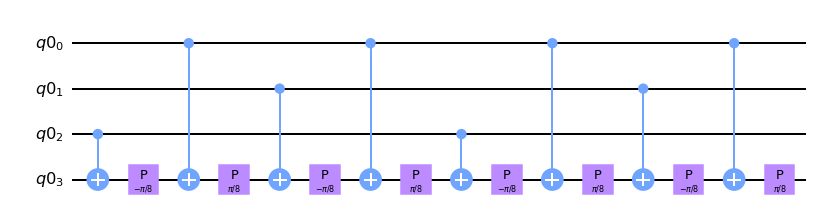

In [6]:
def new_mcrz(qc,theta,q_controls,q_target):
    n = len(q_controls)
    newtheta = -theta/2**n
    a = lambda n: log(n-(n&(n-1)),2)
    qc.cx(q_controls[n-1],q_target)
    qc.p(newtheta,q_target)  # qc.u1 was deprecated
    for i in range(1,2**(n)):
        qc.cx(q_controls[int(a(i))],q_target)
        qc.p((-1)**i*newtheta,q_target) # qc.u1 was deprecated
QuantumCircuit.new_mcrz = new_mcrz

qc.new_mcrz(pi,[q[0],q[1],q[2]],q[3])
qc.draw()

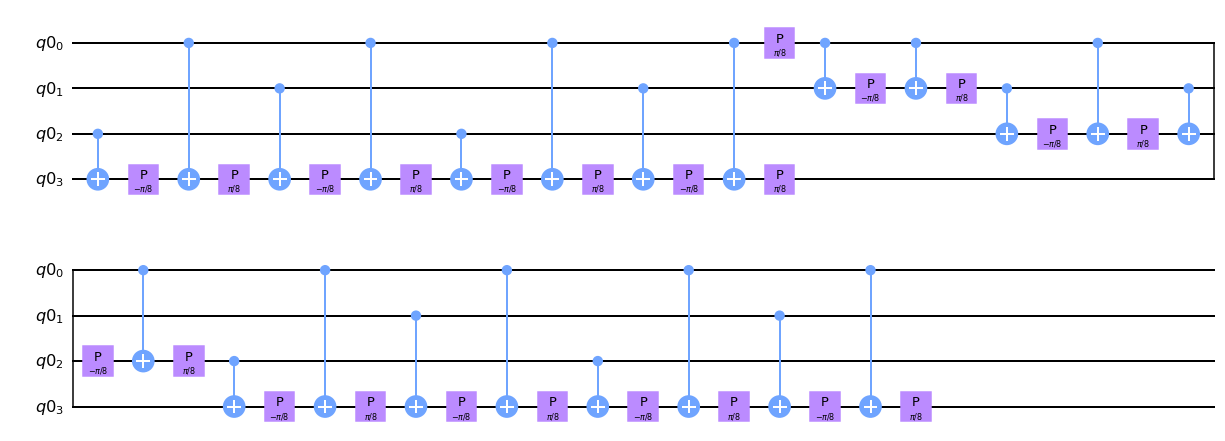

In [7]:
def new_mcz(qc,q_controls,q_target):
    L = q_controls + [q_target]
    n = len(L)
    qc.p(pi/2**(n-1),L[0]) # qc.u1 was deprecated
    for i in range(2,n+1):
        qc.new_mcrz(pi/2**(n-i),L[0:i-1],L[i-1])
QuantumCircuit.new_mcz = new_mcz

qc.new_mcz([q[0],q[1],q[2]],q[3])
qc.draw()

<a id="def-oracle"></a>
### Main definition


In [8]:
def create_oracle_from_file(filename, method = 'standard'):
    '''
     Returns an oracle for Grover's algorithm
    
     filename: one of the csv files prepared by Andres
     type: standart, qw
    '''
    
    try:
        bitmap, solution = table_to_strings(filename)
    except FileNotFoundError:
        print('File Not Found: ', filename)
        return None
    
    n = len(solution)
    oracle = QuantumCircuit(n)

    for i in range(n):
        if solution[n-i-1] == '0':
            oracle.x(i)
    
    if method == 'standard':
        oracle.h(n-1)
        oracle.mct(list(range(0,n-1)), n-1, mode='noancilla')
        oracle.h(n-1)
    elif method == 'qw':
        oracle.new_mcz(list(range(0,n-1)), n-1)
    else:
        raise ValueError
    
    for i in range(n):
        if solution[n-i-1] == '0':
            oracle.x(i)

    return oracle

<a id='examples-oracle'></a>
### Sanity checks 

You may skip this subsection.

In [9]:
table = 'tables-3q/3qubit-6.csv'
#table = 'tables-4q/4qubit-1.csv'
bitmap, solution = table_to_strings(table) 
n = len(solution)

In [10]:
print(f'You are checking a truth table for {n} bits, with solution = {solution}.')

You are checking a truth table for 3 bits, with solution = 110.


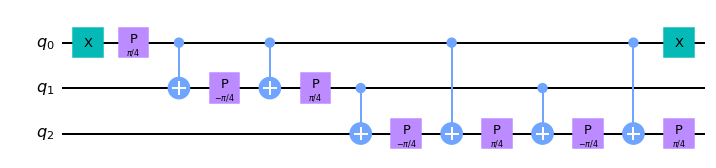

In [11]:
oracle = create_oracle_from_file(table, method = 'qw')
oracle.draw()  # for now, q0 is the least significant bit, but we can change it later... bit ordering in Qiskit is a mess!

Let's check whether the oracle is marking the state it is supposed to mark: 

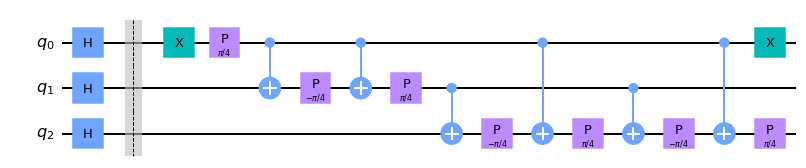

In [12]:
preparation = QuantumCircuit(n)

preparation.h(range(n))
preparation.barrier()
full = preparation.compose(oracle)

full.draw()

In [13]:
backend = Aer.get_backend('statevector_simulator')
job = execute(full, backend)
result = job.result()
outputstate = result.get_statevector(full, decimals=3)

for i in range(2**n):
    if int(solution, 2) == i:
        print(format(i, '0%db' % (n)), outputstate[i], '<-- should be negative')
    else:
        print(format(i, '0%db' % (n)), outputstate[i])

000 (0.354+0j)
001 (0.354+0j)
010 (0.354+0j)
011 (0.354+0j)
100 (0.354+0j)
101 (0.354+0j)
110 (-0.354-0j) <-- should be negative
111 (0.354+0j)


<a id="implementing-reflection"></a>
## 2. Implementing the reflection

In [9]:
def create_reflection(n, method = 'standard'):
    reflection = QuantumCircuit(n)
    
    reflection.h(range(n))
    reflection.x(range(n))
    
    if method == 'standard':
        reflection.h(n-1)
        reflection.mct(list(range(n-1)), n-1, mode='noancilla')
        reflection.h(n-1)
    elif method == 'qw':
        reflection.new_mcz(list(range(n-1)), n-1)
    else:
        raise ValueError
    
    reflection.x(range(n))
    reflection.h(range(n))
    
    return reflection

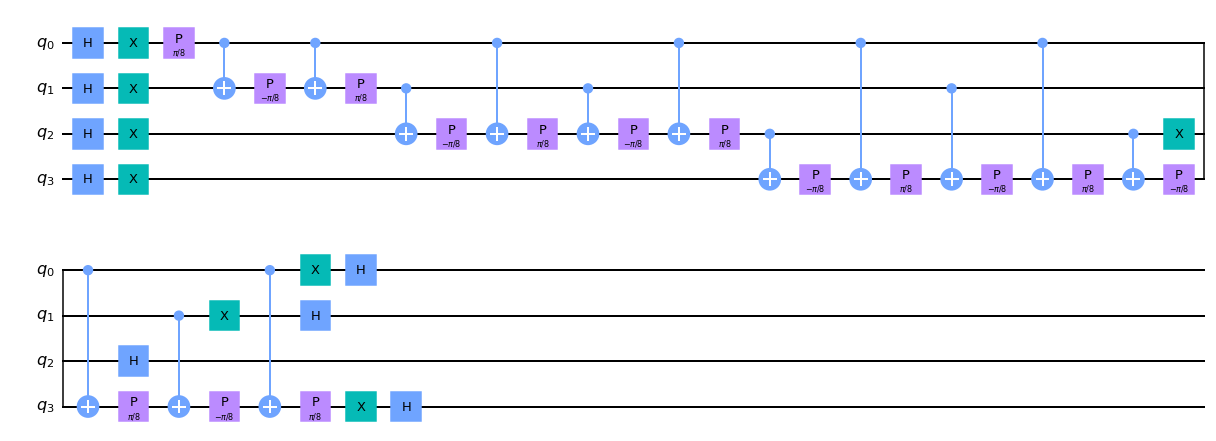

In [10]:
reflection = create_reflection(4, method = 'qw')
reflection.draw()

<a id="implementing-grover"></a>
## 3. Implementing Grover

In [11]:
def create_grover_circuit(filename, iterations = None, method = 'standard'):
    
    bitmap, solution = table_to_strings(filename)
    N = len(bitmap)
    n = len(solution)
    
    if iterations is None:
        iterations = int(np.pi*np.sqrt(N)/4)
    
    grover = QuantumCircuit(n, n)
    grover.h(range(n))
    #grover.barrier()
        
    for _ in range(iterations):
        grover = grover.compose(create_oracle_from_file(filename, method))
        grover = grover.compose(create_reflection(n, method))
        #grover.barrier()
        
    grover.measure(list(range(n)), list(range(n)))
        
    return grover

In [12]:
def improve_circuit(circ, device, iterations = 100, verbose = False):

    best_circ = transpile(circ, backend = device, optimization_level=3)
    for _ in range(iterations):
        circ_t = transpile(circ, backend = device, optimization_level=3)
        if circ_t.num_nonlocal_gates() < best_circ.num_nonlocal_gates():
            best_circ = circ_t
            if verbose:
                print('Reduced number of CNOTs: ', best_circ.num_nonlocal_gates())
        elif (circ_t.num_nonlocal_gates() == best_circ.num_nonlocal_gates()) and (circ_t.depth() < best_circ.depth()):
            best_circ = circ_t
            if verbose:
                print('Reduced depth: ', best_circ.depth())

    if verbose:
        print(best_circ.count_ops(), best_circ.depth())
        
    return best_circ

<a id="grover-testing"></a>
### Sanity checks

You may skip this subsection.

In [51]:
table = 'tables-3q/3qubit-5.csv'
#table = 'tables-4q/4qubit-1.csv'
bitmap, solution = table_to_strings(table) 
n = len(solution)

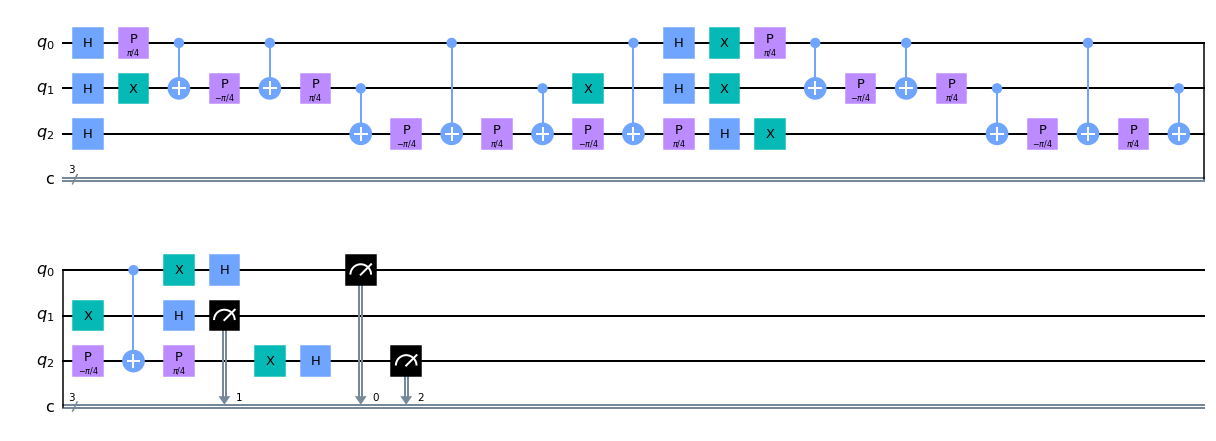

In [52]:
grover = create_grover_circuit(table, iterations=1, method = 'qw')
grover.draw()

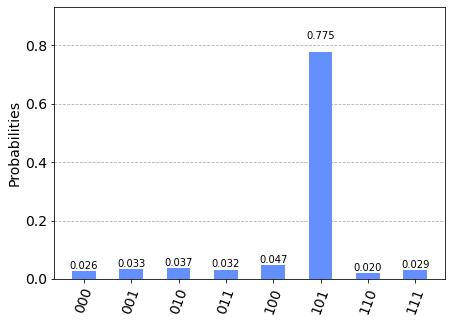

In [53]:
backend = Aer.get_backend('qasm_simulator')
job = execute(grover, backend)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [54]:
print(f'The solution found by Grover\'s algorithm is {counts.most_frequent()}')
print(f'It should find {solution}.')

The solution found by Grover's algorithm is 101
It should find 101.


<a id="experiment"></a>
## 4. Preliminary experiments  

You may skip this section.

In [39]:
provider = IBMQ.get_provider(hub='ibm-q-research', group='lncc-2', project='main')
#provider = IBMQ.get_provider(hub='ibm-q-research', group='lncc-2', project='dmdgp')

In [40]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_casablanca') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQSimulator('simulator_statevector') from

In [41]:
backend = provider.get_backend('ibm_lagos')

In [112]:
table = 'tables-3q/3qubit-5.csv'
#table = 'tables-4q/4qubit-0.csv'
bitmap, solution = table_to_strings(table) 
n = len(solution)
grover = create_grover_circuit(table, iterations=1, method = 'qw')
print(grover.count_ops())

OrderedDict([('p', 14), ('cx', 12), ('h', 9), ('x', 8), ('measure', 3)])


In [120]:
best_grover = improve_circuit(grover, backend)

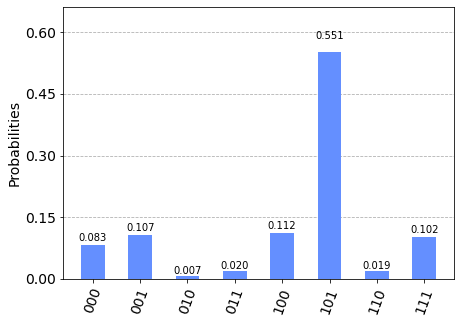

In [121]:
job = execute(best_grover, backend, shots=1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [122]:
print(f'The solution find by Grover is {counts.most_frequent()}.\nIt should find {solution}.')

The solution find by Grover is 101.
It should find 101.


<a id="final"></a>
## 5. Final experiments

In [13]:
provider = IBMQ.get_provider(hub='ibm-q-research', group='lncc-2', project='main')
#provider = IBMQ.get_provider(hub='ibm-q-research', group='lncc-2', project='dmdgp')

In [14]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_casablanca') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-research', group='lncc-2', project='main')>,
 <IBMQSimulator('simulator_statevector') from

In [15]:
backend = provider.get_backend('ibm_lagos')

<a id="aux-final"></a>
### 5.1 Auxiliary functions

In [10]:
def counts_to_pdf(counts):
    '''
    Converts a Qiskit result (counts dictionary) into a probability distribution funcion (numpy array)
    '''
    pdf = np.zeros(len(counts))
    for key in counts.keys(): 
        pdf[int(key, 2)] = float(counts[key])
    pdf = pdf/sum(pdf)
    return pdf

In [17]:
def tvd(a, b): 
    '''
    Calculates total variation distance.
    '''
    
    if isinstance(a, dict):
        pdfA = counts_to_pdf(a)
    elif isinstance(a, np.ndarray):
        pdfA = a
    else:
        raise TypeError('first argument should be either a dictionary or a numpy array')
        
    if isinstance(b, dict):
        pdfB = counts_to_pdf(b)
    elif isinstance(b, np.ndarray):
        pdfB = b
    else:
        raise TypeError('second argument should be either a dictionary or a numpy array')
               
    result = 0.5 * np.sum( np.abs( pdfA - pdfB ) )
    return result


In [18]:
def hellinger(a, b):
    '''
    Calculates Hellinger distance
    '''
    if isinstance(a, dict):
        pdfA = counts_to_pdf(a)
    elif isinstance(a, np.ndarray):
        pdfA = a
    else:
        raise TypeError('first argument should be either a dictionary or a numpy array')
        
    if isinstance(b, dict):
        pdfB = counts_to_pdf(b)
    elif isinstance(b, np.ndarray):
        pdfB = b
    else:
        raise TypeError('second argument should be either a dictionary or a numpy array')
        
    result = np.sqrt( 0.5 * np.sum( ( np.sqrt( pdfA ) - np.sqrt( pdfB ) ) ** 2 ) )
    return result

In [19]:
def fidelity(a, b, method = 'tvd'):
    if method == 'tvd':
        return 1 - tvd(a, b)
    elif method == 'hellinger':
        return 1 - hellinger(a, b)
    else:
        raise ValueError

In [20]:
def sum_counts(list_of_counts):
    '''
    Converts a list of experimental results (a list of Python dictionaries, or "counts") into a single result (a single 
    Python dictionary, or a "count").
    '''
    result = list_of_counts[0]
    for i in range(1, len(list_of_counts)):
        for key in list_of_counts[i].keys():
            result[key] += list_of_counts[i][key]
    return result

In [21]:
def get_success_probability(counts, solution):
    pdf = counts_to_pdf(counts)
    return pdf[solution]

In [22]:
def selectivity(counts, solution):
    pdf = counts_to_pdf(counts)
    target_prob = pdf[solution]
    max_nontarget_prob = np.amax(pdf[np.arange(len(pdf)) != solution])
    return target_prob / max_nontarget_prob

<a id="main-final"></a>
### 5.2 Main code

#### I. Obtaining reference results with simulation

First of all, I will obtain all the reference results (by running the simulation of the exact algorithm without errors).  

Sketch:
- for each input file do
   - for each number of oracle calls
      - run reference experiment (simulation without errors) using `standard` gates
      - save result (for example, `tables-3q/3qubit-0-1call-ref.json`)
      - run reference experiment (simulation without errors) using `qw` gates
      - save result (for example, `tables-3q/3qubit-0-1call-qw.json`)

In [20]:
n = 3
max_iterations = int(np.pi*np.sqrt(2**n)/4)
print(max_iterations)

2


In [21]:
for filename in os.listdir('./tables-3q'):
    if filename.endswith(".csv"):
        for it in range(1, max_iterations + 1):
            grover = create_grover_circuit(os.path.join('./tables-3q', filename), method='standard', iterations=it)
            #backend = provider.get_backend('ibmq_qasm_simulator')
            backend = Aer.get_backend('qasm_simulator')
            job = execute(grover, backend, shots=8192)
            result = job.result()
            reference_counts = result.get_counts()

            pre, ext = os.path.splitext(filename)
            outfile = open('./tables-3q/' + pre + '-ref-' + str(it) + 'call-std.json', 'wt')
            json.dump(reference_counts, outfile)
            outfile.close()
            
            grover = create_grover_circuit(os.path.join('./tables-3q', filename), method='qw', iterations=it)
            #backend = provider.get_backend('ibmq_qasm_simulator')
            backend = Aer.get_backend('qasm_simulator')
            job = execute(grover, backend, shots=8192)
            result = job.result()
            reference_counts = result.get_counts()

            pre, ext = os.path.splitext(filename)
            outfile = open('./tables-3q/' + pre + '-ref-' + str(it) + 'call-qw.json', 'wt')
            json.dump(reference_counts, outfile)
            outfile.close()

#### II. Running on the quantum devices
Now, I will run all the experiments in the real quantum computers. Lagos, Santiago and Bogota seem good for our experiments, but is important to schedule them in advance. And I don't think every computer can be scheduled.  

Sketch:
- for each backend do
   - for each input file do
      - for iterations from 1 to max do
         - run with `standard` gates
         - save results (for example, `tables-4q/4qubit-0-jakarta-std.json`)
      
         - run with `qw` gates
         - save results (for example, `tables-4q/4qubit-0-jakarta-qw.json`)

In [20]:
#real_devices = ['ibm_lagos', 'ibmq_santiago', 'ibmq_bogota']
real_devices = ['ibmq_bogota']

In [31]:
for device in real_devices:
    for filename in os.listdir('./tables-3q'):
        if filename.endswith(".csv"):
            for num_iterations in range(1, max_iterations + 1):
            #for num_iterations in [2]:
                # Standard method
                grover = create_grover_circuit(os.path.join('./tables-3q', filename), iterations = num_iterations, method = 'standard')
                backend = provider.get_backend(device)
                best_grover = improve_circuit(grover, backend)
                job = execute(best_grover, backend, shots=8192)
                result = job.result()
                real_counts = result.get_counts()

                pre, ext = os.path.splitext(filename)
                outfile = open('./tables-3q/' + pre + '-' + device + '-' + str(num_iterations) + 'call-std.json', 'wt')
                json.dump(real_counts, outfile)
                outfile.close()

                # QW method
                grover = create_grover_circuit(os.path.join('./tables-3q', filename),  iterations = num_iterations, method = 'qw')
                backend = provider.get_backend(device)
                best_grover = improve_circuit(grover, backend)
                job = execute(best_grover, backend, shots=8192)
                result = job.result()
                real_counts = result.get_counts()

                pre, ext = os.path.splitext(filename)
                outfile = open('./tables-3q/' + pre + '-' + device + '-' + str(num_iterations) + 'call-qw.json', 'wt')
                json.dump(real_counts, outfile)
                outfile.close()


#### III. Analysing the results

Finding the best results

In [23]:
best_prob = {'value': 0.0, 'solution': None, 'calls': None, 'method': None, 'device': None}
best_selectivity = {'value': 0.0, 'solution': None, 'calls': None, 'method': None, 'device': None}
best_fidelity_tvd = {'value': 0.0, 'solution': None, 'calls': None, 'method': None, 'device': None}
best_fidelity_hellinger = {'value': 0.0, 'solution': None, 'calls': None, 'method': None, 'device': None}

for solution in range(8):
    for calls in [1,2]:
        for method in ['std', 'qw']:
        
            infile = open(f'./tables-3q/3qubit-{solution}-ref-{calls}call-{method}.json', 'rt')
            reference_counts = json.load(infile)
            infile.close()

            for device in ['ibm_lagos', 'ibmq_santiago', 'ibmq_bogota']:
                infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-{method}.json', 'rt')
                counts = json.load(infile)
                infile.close()

                prob = get_success_probability(counts, solution)
                if prob > best_prob['value']:
                    best_prob['value'] = prob
                    best_prob['solution'] = solution
                    best_prob['calls'] = calls
                    best_prob['method'] = method
                    best_prob['device'] = device
                
                selec = selectivity(counts, solution)
                if selec > best_selectivity['value']:
                    best_selectivity['value'] = selec
                    best_selectivity['solution'] = solution
                    best_selectivity['calls'] = calls
                    best_selectivity['method'] = method
                    best_selectivity['device'] = device
                    
                fidelity_tvd = fidelity(counts, reference_counts, method = 'tvd')
                if fidelity_tvd > best_fidelity_tvd['value']:
                    best_fidelity_tvd['value'] = fidelity_tvd
                    best_fidelity_tvd['solution'] = solution
                    best_fidelity_tvd['calls'] = calls
                    best_fidelity_tvd['method'] = method
                    best_fidelity_tvd['device'] = device
                
                fidelity_hellinger = fidelity(counts, reference_counts, method = 'hellinger')
                if fidelity_hellinger > best_fidelity_hellinger['value']:
                    best_fidelity_hellinger['value'] = fidelity_tvd
                    best_fidelity_hellinger['solution'] = solution
                    best_fidelity_hellinger['calls'] = calls
                    best_fidelity_hellinger['method'] = method
                    best_fidelity_hellinger['device'] = device
            
print('best_prob = ', best_prob)
print('best_selectivity = ', best_selectivity)
print('best_fidelity_tvd = ', best_fidelity_tvd)
print('best_fidelity_hellinger = ', best_fidelity_hellinger)

best_prob =  {'value': 0.6787109375, 'solution': 2, 'calls': 1, 'method': 'qw', 'device': 'ibmq_santiago'}
best_selectivity =  {'value': 11.896247240618102, 'solution': 0, 'calls': 1, 'method': 'std', 'device': 'ibmq_santiago'}
best_fidelity_tvd =  {'value': 0.89404296875, 'solution': 2, 'calls': 1, 'method': 'qw', 'device': 'ibmq_santiago'}
best_fidelity_hellinger =  {'value': 0.89404296875, 'solution': 2, 'calls': 1, 'method': 'qw', 'device': 'ibmq_santiago'}


Now, I plot the best results. The best according to most criteria (except selectivity) was `'solution': 2, 'calls': 1, 'method': 'qw', 'device': 'ibmq_santiago'`.

I will first compare the algorithm with standard (std) gates and with improved (qw) gates.

In [11]:
solution = 2
calls = 1
device = 'ibmq_santiago'

infile = open(f'./tables-3q/3qubit-{solution}-ref-{calls}call-std.json', 'rt')
reference_counts = json.load(infile)
infile.close()

infile = open(f'./tables-3q/3qubit-{solution}-ref-{calls}call-qw.json', 'rt')
reference_qw_counts = json.load(infile)
infile.close()

infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-std.json', 'rt')
std_counts_1 = json.load(infile)
infile.close()

infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-qw.json', 'rt')
qw_counts_1 = json.load(infile)
infile.close()

#fig = plot_histogram([std_counts_1, qw_counts_1, reference_counts, reference_qw_counts], legend=[f'{device} (standard)', f'{device} (improved)', 'simulated (standard)', 'simulated (improved)'], bar_labels = False, color = [ '#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB'])
# color pallete from https://personal.sron.nl/~pault/ (Fig. 3, "Vibrant")

fig = plot_histogram([std_counts_1, qw_counts_1, reference_counts, reference_qw_counts], legend=[f'{device} (standard)', f'{device} (improved)', 'simulated (standard)', 'simulated (improved)'], bar_labels = False, color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
# color pallete from https://personal.sron.nl/~pault/ (Fig. 3, "Bright")


fig.axes[0].set_ylim(0.0, 1.0)
fig.axes[0].set_yticks(np.linspace(0.0, 1.0, 11))
fig.axes[0].legend(loc='upper right')
fig.savefig(f'./tables-3q/{device}-vs-simulated-{calls}-calls-solution-{solution:03b}.png', bbox_inches='tight')

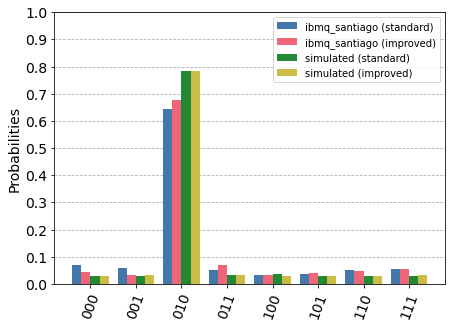

In [12]:
fig

In [21]:
print(f'Solution: |{solution:03b}>, Calls: {calls}, Device: {device}\n')
print('ket  \t real std\t real qw\t sim std\t sim qw')
print('----------------------------------------------------')
for ket in range(8):
    reference_pdf = counts_to_pdf(reference_counts)
    reference_qw_pdf = counts_to_pdf(reference_qw_counts)
    std_pdf_1 = counts_to_pdf(std_counts_1)
    qw_pdf_1 = counts_to_pdf(qw_counts_1)
    print(f'|{ket:03b}> \t {std_pdf_1[ket]:.3f}   \t {qw_pdf_1[ket]:.3f}   \t {reference_pdf[ket]:.3f}   \t {reference_qw_pdf[ket]:.3f}')

Solution: |010>, Calls: 1, Device: ibmq_santiago

ket  	 real std	 real qw	 sim std	 sim qw
----------------------------------------------------
|000> 	 0.070   	 0.043   	 0.030   	 0.029
|001> 	 0.058   	 0.031   	 0.030   	 0.031
|010> 	 0.644   	 0.679   	 0.783   	 0.785
|011> 	 0.053   	 0.069   	 0.032   	 0.031
|100> 	 0.032   	 0.032   	 0.037   	 0.031
|101> 	 0.036   	 0.041   	 0.030   	 0.030
|110> 	 0.053   	 0.049   	 0.030   	 0.030
|111> 	 0.054   	 0.056   	 0.028   	 0.032


In [13]:
solution = 2
calls = 2
device = 'ibmq_santiago'

infile = open(f'./tables-3q/3qubit-{solution}-ref-{calls}call-std.json', 'rt')
reference_counts = json.load(infile)
infile.close()

infile = open(f'./tables-3q/3qubit-{solution}-ref-{calls}call-qw.json', 'rt')
reference_qw_counts = json.load(infile)
infile.close()

infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-std.json', 'rt')
std_counts_1 = json.load(infile)
infile.close()

infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-qw.json', 'rt')
qw_counts_1 = json.load(infile)
infile.close()

fig = plot_histogram([std_counts_1, qw_counts_1, reference_counts, reference_qw_counts], legend=[f'{device} (standard)', f'{device} (improved)', 'simulated (standard)', 'simulated (improved)'], bar_labels = False, color = [ '#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB'])
# color pallete from https://personal.sron.nl/~pault/ (Fig. 3, "Vibrant")

fig = plot_histogram([std_counts_1, qw_counts_1, reference_counts, reference_qw_counts], legend=[f'{device} (standard)', f'{device} (improved)', 'simulated (standard)', 'simulated (improved)'], bar_labels = False, color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
# color pallete from https://personal.sron.nl/~pault/ (Fig. 3, "Bright")


fig.axes[0].set_ylim(0.0, 1.0)
fig.axes[0].set_yticks(np.linspace(0.0, 1.0, 11))
fig.axes[0].legend(loc='upper right')
fig.savefig(f'./tables-3q/{device}-vs-simulated-{calls}-calls-solution-{solution:03b}.png', bbox_inches='tight')

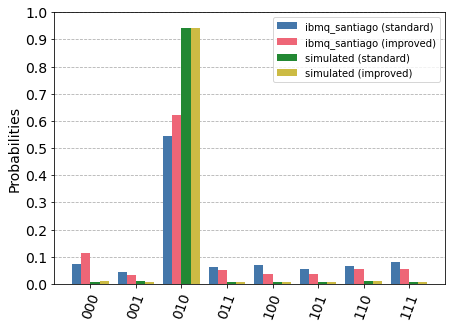

In [14]:
fig

In [24]:
print(f'Solution: |{solution:03b}>, Calls: {calls}, Device: {device}\n')
print('ket  \t real std\t real qw\t sim std\t sim qw')
print('----------------------------------------------------')
for ket in range(8):
    reference_pdf = counts_to_pdf(reference_counts)
    reference_qw_pdf = counts_to_pdf(reference_qw_counts)
    std_pdf_1 = counts_to_pdf(std_counts_1)
    qw_pdf_1 = counts_to_pdf(qw_counts_1)
    print(f'|{ket:03b}> \t {std_pdf_1[ket]:.3f}   \t {qw_pdf_1[ket]:.3f}   \t {reference_pdf[ket]:.3f}   \t {reference_qw_pdf[ket]:.3f}')

Solution: |010>, Calls: 2, Device: ibmq_santiago

ket  	 real std	 real qw	 sim std	 sim qw
----------------------------------------------------
|000> 	 0.075   	 0.115   	 0.007   	 0.010
|001> 	 0.045   	 0.035   	 0.010   	 0.008
|010> 	 0.545   	 0.620   	 0.941   	 0.943
|011> 	 0.061   	 0.050   	 0.008   	 0.008
|100> 	 0.069   	 0.035   	 0.008   	 0.007
|101> 	 0.055   	 0.036   	 0.008   	 0.008
|110> 	 0.067   	 0.054   	 0.009   	 0.009
|111> 	 0.082   	 0.054   	 0.009   	 0.007


Now, I should compare diferent quantum computers.

In [50]:
solution = 2
calls = 1

#infile = open(f'./tables-3q/3qubit-{solution}-ref-{calls}call-std.json', 'rt')
#reference_counts = json.load(infile)
#infile.close()

devices = ['ibm_lagos', 'ibmq_santiago', 'ibmq_bogota']
device_counts_std = []
device_counts_qw = []

for device in devices:
    infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-std.json', 'rt')
    device_counts_std.append(json.load(infile))
    infile.close()
    
    infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-qw.json', 'rt')
    device_counts_qw.append(json.load(infile))
    infile.close()

#fig = plot_histogram([*device_counts, reference_counts], legend=[*devices, 'simulated'], bar_labels = False)
fig = plot_histogram([device_counts_std[0], device_counts_qw[0], device_counts_std[1], device_counts_qw[1], device_counts_std[2], device_counts_qw[2]], legend=['ibm_lagos (standard)', 'ibm_lagos (improved)', 'ibmq_santiago (standard)', 'ibmq_santiago (improved)', 'ibmq_bogota (standard)', 'ibmq_bogota (improved)'], bar_labels = False, color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
# color pallete from https://personal.sron.nl/~pault/ (Fig. 1, "Bright")
fig.axes[0].set_ylim(0.0, 1.0)
fig.axes[0].set_yticks(np.linspace(0.0, 1.0, 11))
fig.axes[0].legend(loc='upper right')
fig.savefig(f'./tables-3q/all-devices-{calls}oracle-calls-solution-{solution:03b}.png', bbox_inches='tight')

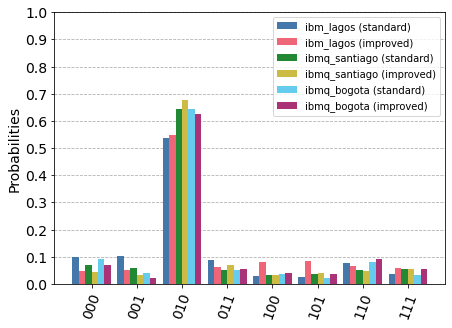

In [51]:
fig

In [47]:
print(f'Solution: |{solution:03b}>, Calls: {calls}, Devices: {devices}\n')
print(f'ket  \t {devices[0]}-std\t {devices[0]}-qw\t {devices[1]}-std\t {devices[1]}-qw\t {devices[2]}-std\t {devices[2]}-qw\t ')
print('-'*120)

device_pdf_std = list(map(counts_to_pdf, device_counts_std))
device_pdf_qw = list(map(counts_to_pdf, device_counts_qw))

for ket in range(8):
    print(f'|{ket:03b}>\t {device_pdf_std[0][ket]:.3f}        \t {device_pdf_qw[0][ket]:.3f}        \t {device_pdf_std[1][ket]:.3f}          \t {device_pdf_qw[1][ket]:.3f}          \t {device_pdf_std[2][ket]:.3f}          \t {device_pdf_qw[2][ket]:.3f}')

Solution: |010>, Calls: 1, Devices: ['ibm_lagos', 'ibmq_santiago', 'ibmq_bogota']

ket  	 ibm_lagos-std	 ibm_lagos-qw	 ibmq_santiago-std	 ibmq_santiago-qw	 ibmq_bogota-std	 ibmq_bogota-qw	 
------------------------------------------------------------------------------------------------------------------------
|000>	 0.098        	 0.048        	 0.070          	 0.043          	 0.090          	 0.069
|001>	 0.105        	 0.051        	 0.058          	 0.031          	 0.042          	 0.024
|010>	 0.538        	 0.547        	 0.644          	 0.679          	 0.643          	 0.627
|011>	 0.089        	 0.062        	 0.053          	 0.069          	 0.051          	 0.057
|100>	 0.030        	 0.082        	 0.032          	 0.032          	 0.038          	 0.039
|101>	 0.026        	 0.084        	 0.036          	 0.041          	 0.023          	 0.037
|110>	 0.078        	 0.066        	 0.053          	 0.049          	 0.080          	 0.093
|111>	 0.036        	 0.060    

In [48]:
solution = 2
calls = 2

#infile = open(f'./tables-3q/3qubit-{solution}-ref-{calls}call-std.json', 'rt')
#reference_counts = json.load(infile)
#infile.close()

devices = ['ibm_lagos', 'ibmq_santiago', 'ibmq_bogota']
device_counts_std = []
device_counts_qw = []

for device in devices:
    infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-std.json', 'rt')
    device_counts_std.append(json.load(infile))
    infile.close()
    
    infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-qw.json', 'rt')
    device_counts_qw.append(json.load(infile))
    infile.close()

#fig = plot_histogram([*device_counts, reference_counts], legend=[*devices, 'simulated'], bar_labels = False)
fig = plot_histogram([device_counts_std[0], device_counts_qw[0], device_counts_std[1], device_counts_qw[1], device_counts_std[2], device_counts_qw[2]], legend=['ibm_lagos (standard)', 'ibm_lagos (improved)', 'ibmq_santiago (standard)', 'ibmq_santiago (improved)', 'ibmq_bogota (standard)', 'ibmq_bogota (improved)'], bar_labels = False, color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
# color pallete from https://personal.sron.nl/~pault/ (Fig. 1, "Bright")
fig.axes[0].set_ylim(0.0, 1.0)
fig.axes[0].set_yticks(np.linspace(0.0, 1.0, 11))
fig.axes[0].legend(loc='upper right')
fig.savefig(f'./tables-3q/all-devices-{calls}oracle-calls-solution-{solution:03b}.png', bbox_inches='tight')

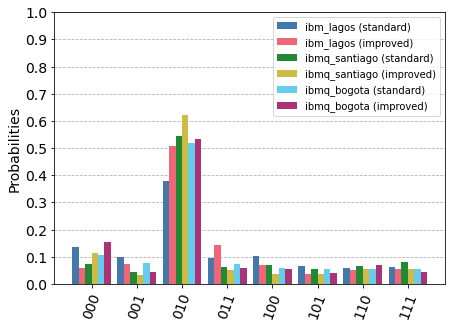

In [49]:
fig

In [44]:
print(f'Solution: |{solution:03b}>, Calls: {calls}, Devices: {devices}\n')
print(f'ket  \t {devices[0]}-std\t {devices[0]}-qw\t {devices[1]}-std\t {devices[1]}-qw\t {devices[2]}-std\t {devices[2]}-qw\t ')
print('-'*120)

device_pdf_std = list(map(counts_to_pdf, device_counts_std))
device_pdf_qw = list(map(counts_to_pdf, device_counts_qw))

for ket in range(8):
    print(f'|{ket:03b}>\t {device_pdf_std[0][ket]:.3f}        \t {device_pdf_qw[0][ket]:.3f}        \t {device_pdf_std[1][ket]:.3f}          \t {device_pdf_qw[1][ket]:.3f}          \t {device_pdf_std[2][ket]:.3f}          \t {device_pdf_qw[2][ket]:.3f}')

Solution: |010>, Calls: 2, Devices: ['ibm_lagos', 'ibmq_santiago', 'ibmq_bogota']

ket  	 ibm_lagos-std	 ibm_lagos-qw	 ibmq_santiago-std	 ibmq_santiago-qw	 ibmq_bogota-std	 ibmq_bogota-qw	 
------------------------------------------------------------------------------------------------------------------------
|000>	 0.136        	 0.058        	 0.075          	 0.115          	 0.106          	 0.154
|001>	 0.099        	 0.074        	 0.045          	 0.035          	 0.076          	 0.045
|010>	 0.377        	 0.506        	 0.545          	 0.620          	 0.517          	 0.533
|011>	 0.095        	 0.145        	 0.061          	 0.050          	 0.075          	 0.058
|100>	 0.103        	 0.071        	 0.069          	 0.035          	 0.059          	 0.054
|101>	 0.068        	 0.038        	 0.055          	 0.036          	 0.055          	 0.041
|110>	 0.060        	 0.053        	 0.067          	 0.054          	 0.057          	 0.071
|111>	 0.063        	 0.054    

In [40]:
calls = 2
device = 'ibmq_bogota'

avg_prob_std = 0.0
avg_selec_std = 0.0

avg_prob_qw = 0.0
avg_selec_qw = 0.0

avg_fidelity_tvd_std = 0.0
avg_fidelity_tvd_qw = 0.0
avg_fidelity_hellinger_std = 0.0
avg_fidelity_hellinger_qw = 0.0

for solution in range(8):
    infile = open(f'./tables-3q/3qubit-{solution}-ref-{calls}call-std.json', 'rt')
    reference_counts = json.load(infile)
    infile.close()
    
    infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-std.json', 'rt')
    counts_std = json.load(infile)
    infile.close()
    
    infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-qw.json', 'rt')
    counts_qw = json.load(infile)
    infile.close()
    
    prob_std = get_success_probability(counts_std, solution)
    avg_prob_std += prob_std
    
    selec_std = selectivity(counts_std, solution)
    avg_selec_std += selec_std
    
    fidelity_tvd_std = fidelity(counts_std, reference_counts, method = 'tvd')
    avg_fidelity_tvd_std += fidelity_tvd_std
    
    fidelity_hellinger_std = fidelity(counts_std, reference_counts, method = 'hellinger')
    avg_fidelity_hellinger_std += fidelity_hellinger_std
    
    fidelity_tvd_qw = fidelity(counts_qw, reference_counts, method = 'tvd')
    avg_fidelity_tvd_qw += fidelity_tvd_qw
    
    fidelity_hellinger_qw = fidelity(counts_qw, reference_counts, method = 'hellinger')
    avg_fidelity_hellinger_qw += fidelity_hellinger_qw
    
    prob_qw = get_success_probability(counts_qw, solution)
    avg_prob_qw += prob_qw
    
    selec_qw = selectivity(counts_qw, solution)
    avg_selec_qw += selec_qw
    
    print(f'Solution |{solution:03b}>, {calls} call(s);')
    print(f'Success prob with std: {prob_std}, Success prob with qw: {prob_qw},')
    print(f'Selectivity with std: {selec_std}, Selectivity with qw: {selec_qw},')
    print(f'Fidelity (tvd) with std: {fidelity_tvd_std}, Fidelity (tvd) with qw: {fidelity_tvd_qw},')
    print(f'Fidelity (hellinger) with std: {fidelity_hellinger_std}, Fidelity (hellinger) with qw: {fidelity_hellinger_qw}.\n\n')

avg_prob_std /= 8
avg_prob_qw /= 8
avg_selec_std /= 8
avg_selec_qw /= 8

avg_fidelity_tvd_std /= 8
avg_fidelity_tvd_qw /= 8
avg_fidelity_hellinger_std /= 8
avg_fidelity_hellinger_qw /= 8

print(f'Avg prob std  = {avg_prob_std:.3f}')
print(f'Avg prob qw   = {avg_prob_qw:.3f}')
print(f'Avg selec std = {avg_selec_std:.3f}')
print(f'Avg selec qw  = {avg_selec_qw:.3f}')

print(f'Avg fidelity (tvd) std       = {avg_fidelity_tvd_std:.3f}')
print(f'Avg fidelity (tvd) qw        = {avg_fidelity_tvd_qw:.3f}')
print(f'Avg fidelity (hellinger) std = {avg_fidelity_hellinger_std:.3f}')
print(f'Avg fidelity (hellinger) qw  = {avg_fidelity_hellinger_qw:.3f}')

Solution |000>, 2 call(s);
Success prob with std: 0.56640625, Success prob with qw: 0.6136474609375,
Selectivity with std: 6.600284495021337, Selectivity with qw: 6.943370165745856,
Fidelity (tvd) with std: 0.62158203125, Fidelity (tvd) with qw: 0.6688232421875,
Fidelity (hellinger) with std: 0.6597950668137915, Fidelity (hellinger) with qw: 0.6931284605042058.


Solution |001>, 2 call(s);
Success prob with std: 0.4747314453125, Success prob with qw: 0.5716552734375,
Selectivity with std: 4.389390519187359, Selectivity with qw: 7.127853881278539,
Fidelity (tvd) with std: 0.5269775390625, Fidelity (tvd) with qw: 0.6239013671875,
Fidelity (hellinger) with std: 0.5934424225916359, Fidelity (hellinger) with qw: 0.6610323676166255.


Solution |010>, 2 call(s);
Success prob with std: 0.5169677734375, Success prob with qw: 0.5333251953125,
Selectivity with std: 4.879032258064516, Selectivity with qw: 3.464710547184774,
Fidelity (tvd) with std: 0.5762939453125, Fidelity (tvd) with qw: 0.592651

In [39]:
calls = 2
device = 'ibm_lagos'

avg_prob_std = 0.0
avg_selec_std = 0.0

avg_prob_qw = 0.0
avg_selec_qw = 0.0

avg_fidelity_tvd_std = 0.0
avg_fidelity_tvd_qw = 0.0
avg_fidelity_hellinger_std = 0.0
avg_fidelity_hellinger_qw = 0.0

for solution in range(8):
    infile = open(f'./tables-3q/3qubit-{solution}-ref-{calls}call-std.json', 'rt')
    reference_counts = json.load(infile)
    infile.close()
    
    infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-std.json', 'rt')
    counts_std = json.load(infile)
    infile.close()
    
    infile = open(f'./tables-3q/3qubit-{solution}-{device}-{calls}call-qw.json', 'rt')
    counts_qw = json.load(infile)
    infile.close()
    
    prob_std = get_success_probability(counts_std, solution)
    avg_prob_std += prob_std
    
    selec_std = selectivity(counts_std, solution)
    avg_selec_std += selec_std
    
    fidelity_tvd_std = fidelity(counts_std, reference_counts, method = 'tvd')
    avg_fidelity_tvd_std += fidelity_tvd_std
    
    fidelity_hellinger_std = fidelity(counts_std, reference_counts, method = 'hellinger')
    avg_fidelity_hellinger_std += fidelity_hellinger_std
    
    fidelity_tvd_qw = fidelity(counts_qw, reference_counts, method = 'tvd')
    avg_fidelity_tvd_qw += fidelity_tvd_qw
    
    fidelity_hellinger_qw = fidelity(counts_qw, reference_counts, method = 'hellinger')
    avg_fidelity_hellinger_qw += fidelity_hellinger_qw
    
    prob_qw = get_success_probability(counts_qw, solution)
    avg_prob_qw += prob_qw
    
    selec_qw = selectivity(counts_qw, solution)
    avg_selec_qw += selec_qw
    
    print(f'Solution |{solution:03b}>, {calls} call(s);')
    print(f'Success prob with std: {prob_std}, Success prob with qw: {prob_qw},')
    print(f'Selectivity with std: {selec_std}, Selectivity with qw: {selec_qw},')
    print(f'Fidelity (tvd) with std: {fidelity_tvd_std}, Fidelity (tvd) with qw: {fidelity_tvd_qw},')
    print(f'Fidelity (hellinger) with std: {fidelity_hellinger_std}, Fidelity (hellinger) with qw: {fidelity_hellinger_qw}.\n\n')

avg_prob_std /= 8
avg_prob_qw /= 8
avg_selec_std /= 8
avg_selec_qw /= 8

avg_fidelity_tvd_std /= 8
avg_fidelity_tvd_qw /= 8
avg_fidelity_hellinger_std /= 8
avg_fidelity_hellinger_qw /= 8

print(f'Avg prob std  = {avg_prob_std}')
print(f'Avg prob qw   = {avg_prob_qw}')
print(f'Avg selec std = {avg_selec_std}')
print(f'Avg selec qw  = {avg_selec_qw}')

print(f'Avg fidelity (tvd) std       = {avg_fidelity_tvd_std}')
print(f'Avg fidelity (tvd) qw        = {avg_fidelity_tvd_qw}')
print(f'Avg fidelity (hellinger) std = {avg_fidelity_hellinger_std}')
print(f'Avg fidelity (hellinger) qw  = {avg_fidelity_hellinger_qw}')

Solution |000>, 2 call(s);
Success prob with std: 0.322998046875, Success prob with qw: 0.56591796875,
Selectivity with std: 1.9455882352941176, Selectivity with qw: 6.132275132275132,
Fidelity (tvd) with std: 0.378173828125, Fidelity (tvd) with qw: 0.62109375,
Fidelity (hellinger) with std: 0.4914960805603713, Fidelity (hellinger) with qw: 0.6589314780569893.


Solution |001>, 2 call(s);
Success prob with std: 0.45654296875, Success prob with qw: 0.538330078125,
Selectivity with std: 3.252173913043478, Selectivity with qw: 4.4410876132930515,
Fidelity (tvd) with std: 0.5087890625, Fidelity (tvd) with qw: 0.590576171875,
Fidelity (hellinger) with std: 0.5798343865186248, Fidelity (hellinger) with qw: 0.6351698918517601.


Solution |010>, 2 call(s);
Success prob with std: 0.3773193359375, Success prob with qw: 0.506103515625,
Selectivity with std: 2.782178217821782, Selectivity with qw: 3.486963835155593,
Fidelity (tvd) with std: 0.4366455078125, Fidelity (tvd) with qw: 0.5654296875,
Fi